In [1]:
# optional but useful for debugging - reimports modules after editing and saving .py files
%load_ext autoreload
%autoreload 2

In [2]:
import astromet
import numpy as np
import matplotlib.pyplot as plt

# an object wich holds all the necessary parameters to generate the astrometric track
params=astromet.params()

# center of mass parameters
params.ra=160     #[deg]
params.dec=-50    #[deg]
params.drac=0     #[mas]
params.ddec=0     #[mas]
params.pmrac=4    #[mas/yr]
params.pmdec=3   #[mas/yr]
params.parallax=2     #[mas]

In [3]:
# random times - a very rough approximation to Gaia eDR3
ts=2016 + ((34/12)*np.sort(np.random.rand(100))-(17/12))

# optionally use the much simpler Kepler equation solver if numba causes errors
#astromet.use_backup=True

# finds the exact position in RAcos(Dec) and Dec [mas]
racs,decs=astromet.track(ts,params)

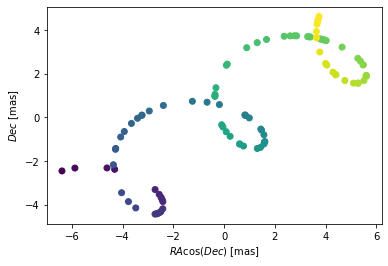

In [4]:
ax=plt.gca()
ax.scatter(racs,decs,c=ts)
ax.set_xlabel(r'$RA \cos(Dec)$ [mas]')
ax.set_ylabel(r'$Dec$ [mas]')
plt.savefig('docs/plots/singleBody.png')
plt.show()

In [5]:
# binary parameters
# (for single stars leave these blank or set l=q)
params.period=2      #[yr]
params.a=2    #[AU]
params.e=0.5
params.q=0.5
params.l=0.1
# viewing angle
params.vphi=4.5   #[rad]
params.vtheta=1.5 #[rad]
params.vomega=5.6 #[rad]
# time of some periapse passage
params.tperi=2016 #[jyear]

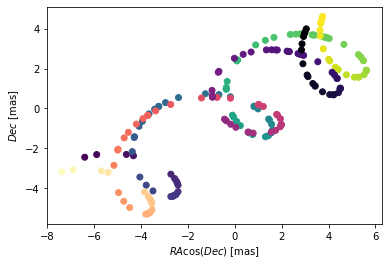

In [6]:
bracs,bdecs=astromet.track(ts,params)

ax=plt.gca()
ax.scatter(racs,decs,c=ts)
ax.scatter(bracs,bdecs,c=ts,cmap='magma_r')
ax.set_xlabel(r'$RA \cos(Dec)$ [mas]')
ax.set_ylabel(r'$Dec$ [mas]')
plt.savefig('docs/plots/twoBody.png')
plt.show()

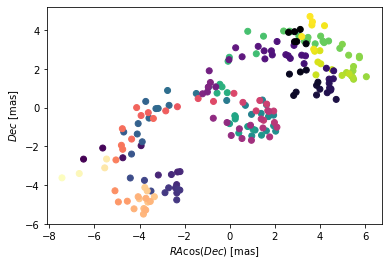

In [7]:
ast_error=0.3 # [mas]

obsracs=racs+ast_error*np.random.randn(ts.size)
obsdecs=decs+ast_error*np.random.randn(ts.size)

bobsracs=bracs+ast_error*np.random.randn(ts.size)
bobsdecs=bdecs+ast_error*np.random.randn(ts.size)

ax=plt.gca()
ax.scatter(obsracs,obsdecs,c=ts)
ax.scatter(bobsracs,bobsdecs,c=ts,cmap='magma_r')
ax.set_xlabel(r'$RA \cos(Dec)$ [mas]')
ax.set_ylabel(r'$Dec$ [mas]')
plt.savefig('docs/plots/twoBodyError.png')
plt.show()

In [8]:
results=astromet.simple_fit(ts,obsracs,obsdecs,ast_error,params.ra,params.dec)
print(results)

{'vis_periods': 67, 'n_obs': 100, 'drac': 0.030680000060700263, 'drac_error': 0.028765974989484112, 'ddec': 0.004901674022852874, 'ddec_error': 0.028623267008114572, 'drac_ddec_corr': -0.0017369159651856986, 'parallax': 2.0256597970860497, 'parallax_error': 0.031088301642718266, 'drac_parallax_corr': -0.10094803024287112, 'ddec_parallax_corr': 0.017206041177889733, 'pmrac': 3.9821115791614083, 'pmrac_error': 0.03517332327239237, 'drac_pmrac_corr': -0.20430297960623336, 'ddec_pmrac_corr': 0.00192529547022491, 'parallax_pmrac_corr': 0.11189648160896948, 'pmdec': 2.985375299340623, 'pmdec_error': 0.0349945503478821, 'drac_pmdec_corr': -0.004951387863295603, 'ddec_pmdec_corr': -0.19411650730582578, 'parallax_pmdec_corr': 0.049048880412852505, 'pmrac_pmdec_corr': 0.005488397145057293, 'UWE': 0.9356120083439586, 'ra_ref': 160, 'dec_ref': -50}


In [9]:
bresults=astromet.simple_fit(ts,bobsracs,bobsdecs,ast_error,params.ra,params.dec)
print(bresults)

{'vis_periods': 67, 'n_obs': 100, 'drac': -0.6637439140363602, 'drac_error': 0.05421558306449721, 'ddec': -0.5250389186371762, 'ddec_error': 0.05394661959565128, 'drac_ddec_corr': -0.0017369159651856984, 'parallax': 1.9515948610842222, 'parallax_error': 0.05859250036409645, 'drac_parallax_corr': -0.10094803024287109, 'ddec_parallax_corr': 0.017206041177889733, 'pmrac': 3.9109770616490747, 'pmrac_error': 0.0662915903328817, 'drac_pmrac_corr': -0.20430297960623334, 'ddec_pmrac_corr': 0.0019252954702249098, 'parallax_pmrac_corr': 0.11189648160896948, 'pmdec': 2.919035393555575, 'pmdec_error': 0.06595465482688848, 'drac_pmdec_corr': -0.004951387863295604, 'ddec_pmdec_corr': -0.19411650730582572, 'parallax_pmdec_corr': 0.049048880412852505, 'pmrac_pmdec_corr': 0.0054883971450572925, 'UWE': 1.7633593359187805, 'ra_ref': 160, 'dec_ref': -50}


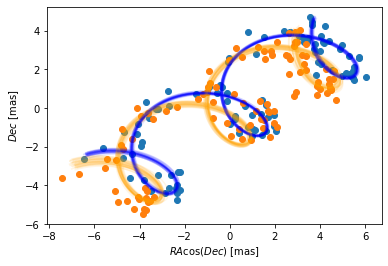

In [10]:
ax=plt.gca()
ax.scatter(obsracs,obsdecs)
ax.scatter(bobsracs,bobsdecs)

plotts=np.linspace(np.min(ts),np.max(ts),200)
fitparams=astromet.params()
bfitparams=astromet.params()
for i in range(32):
    fitparams.ra=160     #[deg]
    fitparams.dec=-50    #[deg]
    fitparams.drac=results['drac']+results['drac_error']*np.random.randn()     #[mas]
    fitparams.ddec=results['ddec']+results['ddec_error']*np.random.randn()     #[mas]
    fitparams.pmrac=results['pmrac']+results['pmrac_error']*np.random.randn()    #[mas/yr]
    fitparams.pmdec=results['pmdec']+results['pmdec_error']*np.random.randn()   #[mas/yr]
    fitparams.parallax=results['parallax']+results['parallax_error']*np.random.randn()     #[mas]
    
    fitracs,fitdecs=astromet.track(plotts,fitparams)
    ax.plot(fitracs,fitdecs,c='blue',alpha=0.1)
    
    bfitparams.ra=160     #[deg]
    bfitparams.dec=-50    #[deg]
    bfitparams.drac=bresults['drac']+bresults['drac_error']*np.random.randn()     #[mas]
    bfitparams.ddec=bresults['ddec']+bresults['ddec_error']*np.random.randn()     #[mas]
    bfitparams.pmrac=bresults['pmrac']+bresults['pmrac_error']*np.random.randn()    #[mas/yr]
    bfitparams.pmdec=bresults['pmdec']+bresults['pmdec_error']*np.random.randn()   #[mas/yr]
    bfitparams.parallax=bresults['parallax']+bresults['parallax_error']*np.random.randn()     #[mas]    

    bfitracs,bfitdecs=astromet.track(plotts,bfitparams)
    ax.plot(bfitracs,bfitdecs,c='orange',alpha=0.1)

ax.set_xlabel(r'$RA \cos(Dec)$ [mas]')
ax.set_ylabel(r'$Dec$ [mas]')
plt.savefig('docs/plots/twoBodyFit.png')
plt.show()

In [14]:
import dev.astromet.astromet as astromet
import numpy as np
import matplotlib.pyplot as plt
import scanninglaw.times

ra=160
dec=-50
c=scanninglaw.source.Source(ra,dec,unit='deg')

dr3_sl=scanninglaw.times.Times(version='dr3_nominal')
sl=dr3_sl(c, return_times=True, return_angles=True)

ts=np.squeeze(np.hstack(sl['times'])).astype('double')
sort=np.argsort(ts)
ts=2010+ts[sort]/365.25
phis=np.squeeze(np.hstack(sl['angles']))[sort].astype('double')

Loading auxilliary data ...
t = 35.918 s
  auxilliary:  17.972 s
          sf:   4.160 s
interpolator:  13.786 s


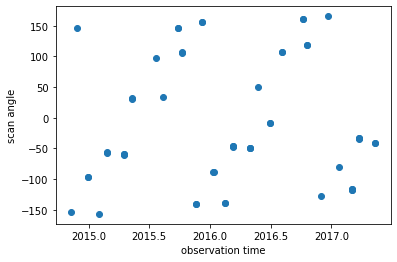

In [15]:
ax=plt.gca()
ax.scatter(ts,phis)
ax.set_xlabel(r'observation time')
ax.set_ylabel(r'scan angle')
plt.savefig('docs/plots/scanningLaw.png')
plt.show()

In [16]:
params=astromet.params()

params.ra=ra
params.dec=dec
params.drac=0
params.ddec=0
params.pmrac=8
params.pmdec=-2
params.parallax=5

params.period=2
params.a=2 
params.e=0.5
params.q=0.5
params.l=0.1

params.vphi=4.5
params.vtheta=1.5
params.vomega=5.6

params.tperi=2016

racs,decs=astromet.track(ts,params)

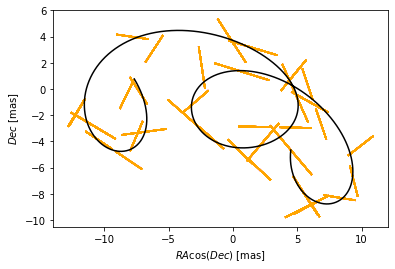

In [35]:
mag=18
al_error=astromet.sigma_ast(mag) # about 1.1 mas at this magnitude
errs=al_error*np.random.randn(phis.size)

radphis=np.deg2rad(phis)

obsracs=racs+errs*np.sin(radphis)
obsdecs=decs+errs*np.cos(radphis)

plotts=np.linspace(np.min(ts),np.max(ts),1000)
plotracs,plotdecs=astromet.track(plotts,params)

ax=plt.gca()
for i in range(ts.size):
    ax.plot([obsracs-al_error*np.sin(radphis),obsracs+al_error*np.sin(radphis)],
            [obsdecs-al_error*np.cos(radphis),obsdecs+al_error*np.cos(radphis)],c='orange')
ax.plot(plotracs,plotdecs,c='k')
ax.set_xlabel(r'$RA \cos(Dec)$ [mas]')
ax.set_ylabel(r'$Dec$ [mas]')
plt.savefig('docs/plots/twoBodyScans')
plt.show()

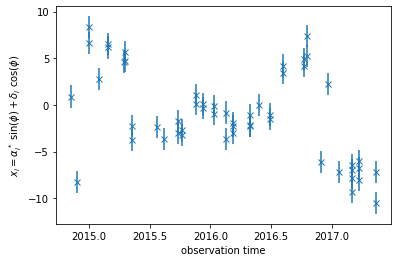

In [32]:
xs=obsracs*np.sin(radphis) + obsdecs*np.cos(radphis)

ax=plt.gca()
ax.errorbar(ts,xs,yerr=al_error,fmt='x')
ax.set_xlabel(r'observation time')
ax.set_ylabel(r'$x_i = \alpha^*_i\ \sin(\phi) + \delta_i\ \cos(\phi)$')
plt.savefig('docs/plots/scanXs.png')
plt.show()

In [33]:
bresults=astromet.gaia_fit(ts,xs,phis,al_error,ra,dec)
print(bresults)

{'astrometric_matched_transits': 5, 'visibility_periods_used': 27, 'astrometric_n_obs_al': 53, 'astrometric_params_solved': 31, 'ra': 159.9999999610181, 'ra_error': 0.23427890849788435, 'dec': -50.00000003847369, 'dec_error': 0.2577500349789146, 'ra_dec_corr': 0.2133421460559281, 'parallax': 0.07457300232082457, 'parallax_error': 0.3150386188133976, 'ra_parallax_corr': -0.07858292995004859, 'dec_parallax_corr': 0.04154273362701287, 'pmra': 8.03378836385093, 'pmra_error': 0.31113955150783973, 'ra_pmra_corr': -0.18081209142306265, 'dec_pmra_corr': 0.037068411492135946, 'parallax_pmra_corr': 0.20354229557874978, 'pmdec': -1.5689878321237263, 'pmdec_error': 0.33495758240814416, 'ra_pmdec_corr': 0.027164079259822282, 'dec_pmdec_corr': -0.22429182786181426, 'parallax_pmdec_corr': 0.004258516730404939, 'pmra_pmdec_corr': 0.19239022877105982, 'astrometric_excess_noise': 0.060866524614082165, 'astrometric_chi2_al': 52.5312832754199, 'astrometric_n_good_obs_al': 53, 'UWE': 1.0461365756461158}
